In [400]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow


#Pre-processing function


In [401]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
		image = cv.resize(image, (image_size, image_size))
		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] 
		return image

#HOG (Histogram of Oriented Gradient) Function

In [402]:
def quantify_image_hog(image) : 
  features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
  return features

#LBP (Local Binary Pattern) Function

In [403]:
def quantify_image_lbp(image) : 
  features = feature.local_binary_pattern(image, 24, 8, method='uniform')

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))
  hist = hist.astype("float")
  hist /= (hist.sum()+ 1e-7)

  return hist

#Melakukan pengetesan, apakah fungsi diatas berjalan dengan baik ?

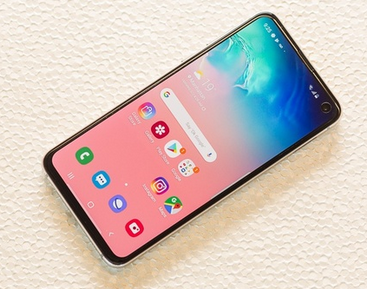

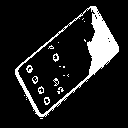

HOG Test
[0. 0. 0. ... 0. 0. 0.] 4356
LBP Test
[9.88769531e-03 7.62939453e-03 1.64794922e-03 6.10351562e-04
 6.10351562e-04 4.27246094e-04 6.10351562e-05 0.00000000e+00
 3.05175781e-04 1.09863281e-03 1.15966797e-03 2.38037109e-03
 2.92968750e-03 4.57763672e-03 3.66210937e-03 4.69970703e-03
 2.80761719e-03 3.54003906e-03 2.74658203e-03 2.80761719e-03
 1.28173828e-03 1.83105469e-03 4.88281250e-04 3.17382812e-03
 8.89038086e-01 5.05981445e-02] 26


In [404]:
image_test = cv.imread('drive/My Drive/Colab_Test/Dataset/Computer Vision/phones/phones.png')

test_preprocessed = preprocess(image_test, image_size = 128)

cv2_imshow(image_test)
cv2_imshow(test_preprocessed)

features_hog = quantify_image_hog(test_preprocessed)
features_lbp = quantify_image_lbp(test_preprocessed)

print("HOG Test")
print(features_hog, len(features_hog))
print("LBP Test")
print(features_lbp, len(features_lbp))

#Data Split Function (Untuk split train dan test)

In [405]:
def load_split(path, image_size = 128, extraction_method = 'hog') : 
  image_paths = list(paths.list_images(path))
  data = []
  labels = []

  for image_path in image_paths :
    label = image_path.split(os.path.sep)[-2]

    image = cv.imread(image_path)
    image = preprocess(image, image_size = image_size)

    if extraction_method == 'hog':
      features = quantify_image_hog(image)
    elif extraction_method == 'lbp' :
      features = quantify_image_lbp(image)

    data.append(features)
    labels.append(label)

  return (np.array(data), np.array(labels))

In [406]:
dataset_dir = '/content/drive/My Drive/Colab_Test/Dataset/Computer Vision/wave_plus_data'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

#**HOG Size = 128**

In [407]:
resize_image_size = 128
extraction_method = 'hog'

In [408]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Machine Learning

In [409]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [410]:
print("List Label Train :")
print(label_train)
print("\n List Label Test : ")
print(label_test)

List Label Train :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 List Label Test : 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [411]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#LinearSVC

In [412]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.7
F1 Score Linear SVC        -> 0.6996662958843158
Precision Score Linear SVC -> 0.7008928571428572
Recall Score Linear SVC    -> 0.7


In [413]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



#Logistic Regression


In [414]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.7
F1 Score Logistic Regression        -> 0.6996662958843158
Precision Score Logistic Regression -> 0.7008928571428572
Recall Score Logistic Regression    -> 0.7


In [415]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



#Random Forest Classifier

In [416]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.767
F1 Score Random Forest Classifier        -> 0.7664071190211346
Precision Score Random Forest Classifier -> 0.7678571428571428
Recall Score Random Forest Classifier    -> 0.7666666666666666


In [417]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.75      0.80      0.77        15

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.77        30
weighted avg       0.77      0.77      0.77        30



In [418]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

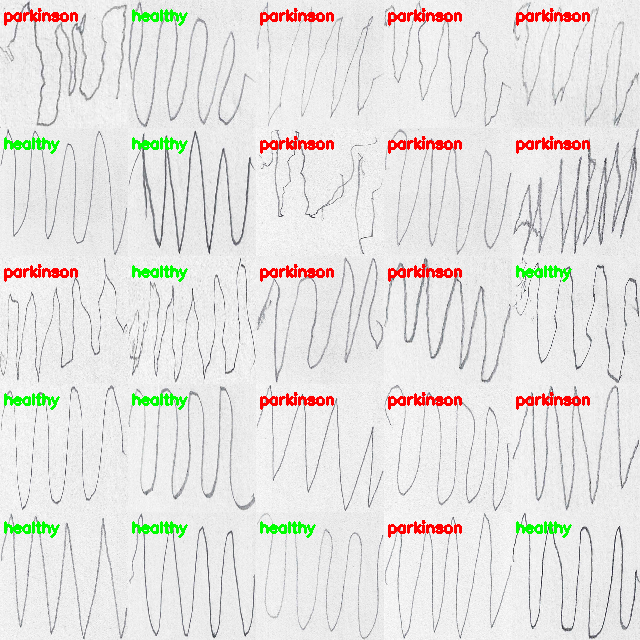

In [419]:
 
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

#**LBP Size = 128**

In [420]:
resize_image_size = 128
extraction_method = 'lbp'

In [421]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#LinearSVC

In [422]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.533
F1 Score Linear SVC        -> 0.5333333333333333
Precision Score Linear SVC -> 0.5333333333333333
Recall Score Linear SVC    -> 0.5333333333333333


In [423]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#Logistic Regression

In [424]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.5
F1 Score Logistic Regression        -> 0.4994438264738599
Precision Score Logistic Regression -> 0.5
Recall Score Logistic Regression    -> 0.5


In [425]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.50      0.47      0.48        15
   parkinson       0.50      0.53      0.52        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.50      0.50      0.50        30



#Random Forest Classifier

In [426]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.633
F1 Score Random Forest Classifier        -> 0.6228571428571429
Precision Score Random Forest Classifier -> 0.6499999999999999
Recall Score Random Forest Classifier    -> 0.6333333333333333


In [427]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.60      0.80      0.69        15
   parkinson       0.70      0.47      0.56        15

    accuracy                           0.63        30
   macro avg       0.65      0.63      0.62        30
weighted avg       0.65      0.63      0.62        30



#**HOG Size = 300**

In [428]:
resize_image_size = 300
extraction_method = 'hog'

In [429]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Linear SVC

In [430]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.6
F1 Score Linear SVC        -> 0.5982142857142858
Precision Score Linear SVC -> 0.6018099547511313
Recall Score Linear SVC    -> 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [431]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.59      0.67      0.62        15
   parkinson       0.62      0.53      0.57        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      0.60        30



#Logistic Regression

In [432]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.7
F1 Score Logistic Regression        -> 0.6996662958843158
Precision Score Logistic Regression -> 0.7008928571428572
Recall Score Logistic Regression    -> 0.7


In [433]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.69      0.73      0.71        15
   parkinson       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



#Random Forest Classifier

In [434]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.633
F1 Score Random Forest Classifier        -> 0.6329254727474972
Precision Score Random Forest Classifier -> 0.6339285714285714
Recall Score Random Forest Classifier    -> 0.6333333333333333


In [435]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.64      0.60      0.62        15
   parkinson       0.62      0.67      0.65        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



#**LBP Size 300**

In [438]:
resize_image_size = 300
extraction_method = 'lbp'

In [439]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Linear SVC

In [440]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.533
F1 Score Linear SVC        -> 0.5333333333333333
Precision Score Linear SVC -> 0.5333333333333333
Recall Score Linear SVC    -> 0.5333333333333333


In [441]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#Logistic Regression

In [442]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.533
F1 Score Logistic Regression        -> 0.5333333333333333
Precision Score Logistic Regression -> 0.5333333333333333
Recall Score Logistic Regression    -> 0.5333333333333333


In [443]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#Random Forest Classifier

In [444]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.733
F1 Score Random Forest Classifier        -> 0.7321428571428572
Precision Score Random Forest Classifier -> 0.7375565610859729
Recall Score Random Forest Classifier    -> 0.7333333333333334


In [445]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.77      0.67      0.71        15
   parkinson       0.71      0.80      0.75        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



#Dari pengujian diatas, saya menambahkan 15 data healthy dan 15 data parkinson pada data training, sehingga didapatkan akurasi paling tinggi dengan metode extaction HOG dengan image size adalah 300 serta dengan menggunakan algoritma Random Forest Classifier, yaitu dengan akurasi 0.767 serta F1 Score 0.764.

#Dengan begitu dapat disimpulkan ada kemungkinan semakinn besar image_size semakin besar juga hasil yang didapatkan, serta semakin banyak dan kompleks data maka dibutuhkan pula beberapa algoritma untuk dijadikan perbandinga.